In [1]:
# Main Imports
import pandas as pd
import numpy as np
from collections import Counter
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve
)

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.preprocessing import PolynomialFeatures

# **Data Exploration**



In [4]:
data = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
# View Data
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [5]:
data.info()  # Data types, nulls
data.describe()  # Summary statistics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
# Missing Values Check
data.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


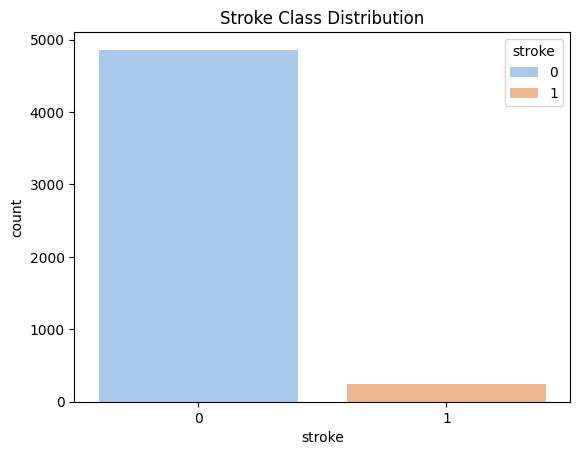

In [7]:
# Class Visualization
sns.countplot(x='stroke', hue='stroke', data=data, palette='pastel')
plt.title('Stroke Class Distribution')
plt.show()

**Insight:** The dataset is **heavily imbalanced**, with the majority of samples labeled as stroke = 0. The minority class (stroke = 1) is significantly underrepresented (≈4%).

**Implication:** Without handling this imbalance, most models will default to predicting the majority class, leading to high accuracy but poor recall for stroke prediction.

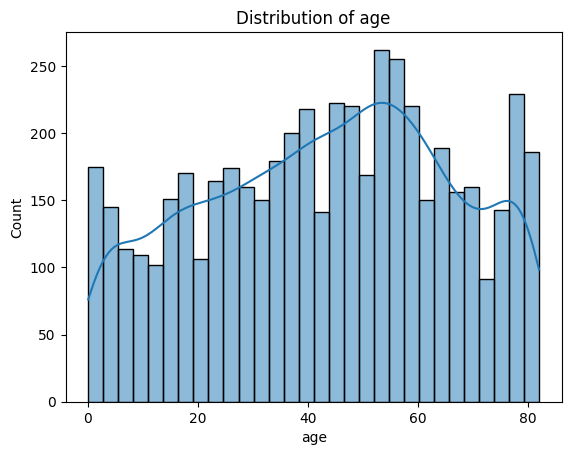

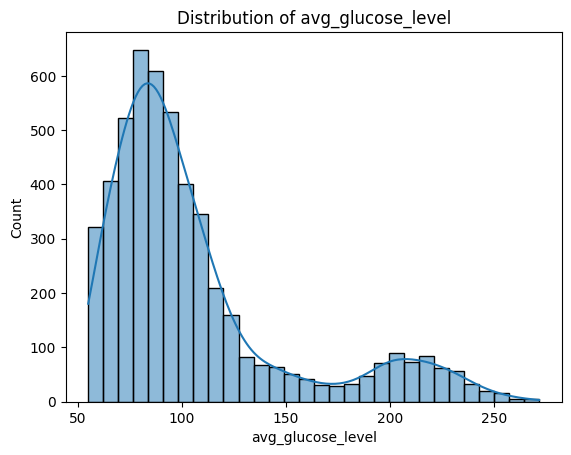

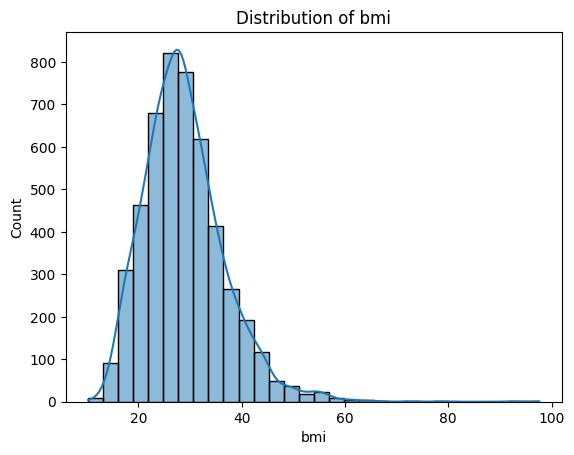

In [8]:
# Numerical Distribution
num_cols = ['age', 'avg_glucose_level', 'bmi']
for col in num_cols:
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

**Age**
*   **Distribution:** Fairly uniform with slight peaks at middle-aged and elderly ranges.
*   **Note:** Stroke cases seem to increase with age — confirming that age is a critical risk factor.

**Avg Glucose Level**
*   **Distribution:** Right-skewed. Many patients have glucose levels below 150, but there are long tails up to 250+.
*   **Implication:** Outliers may influence model behavior — consider transformation or binning if needed.

**BMI**
*   **Distribution:** Approximates a normal distribution but with a long right tail.
*   **Implication:** A few extreme outliers exist (e.g., BMI > 60). May consider capping/extreme value treatment for robustness.

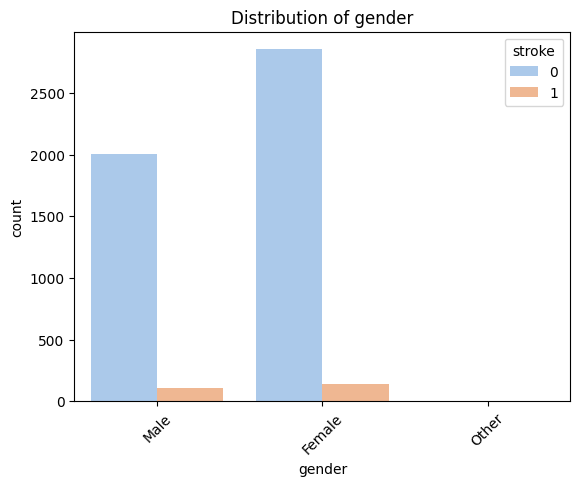

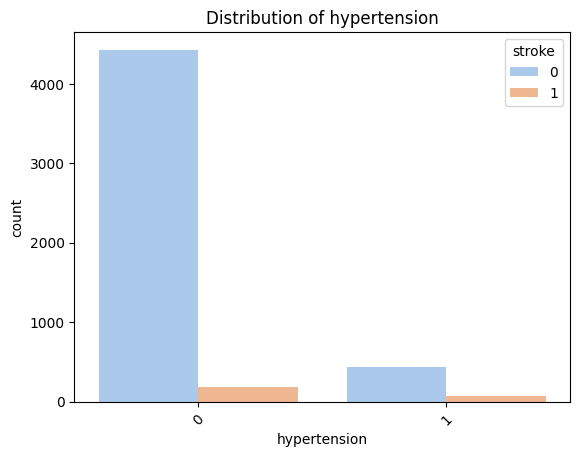

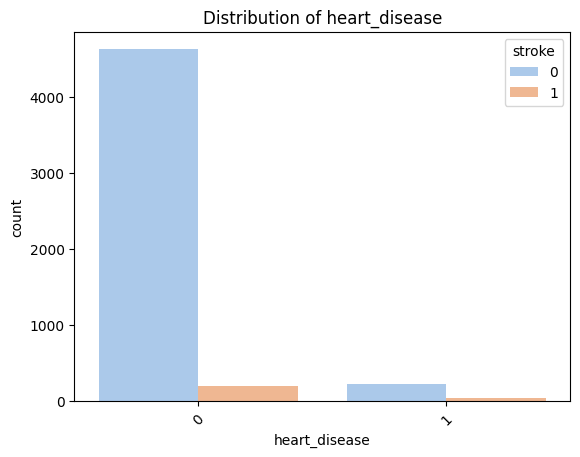

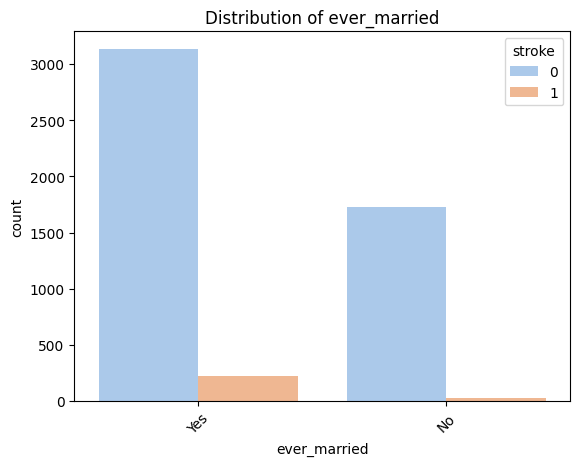

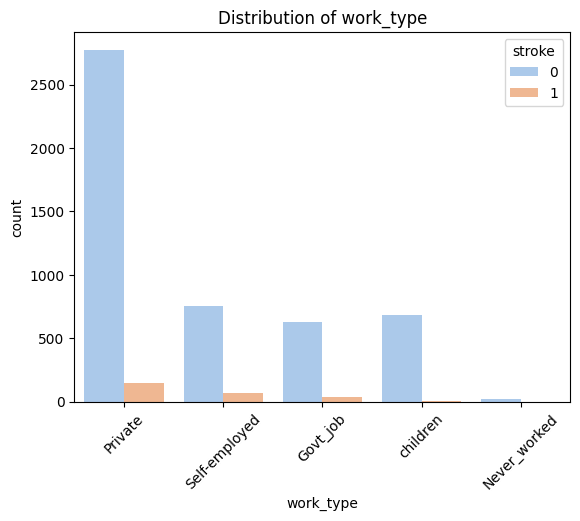

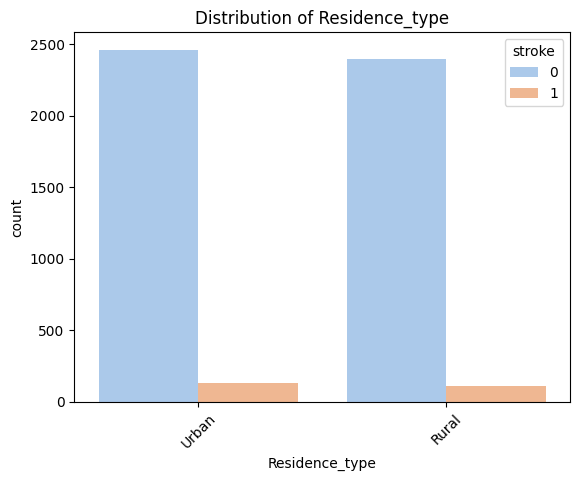

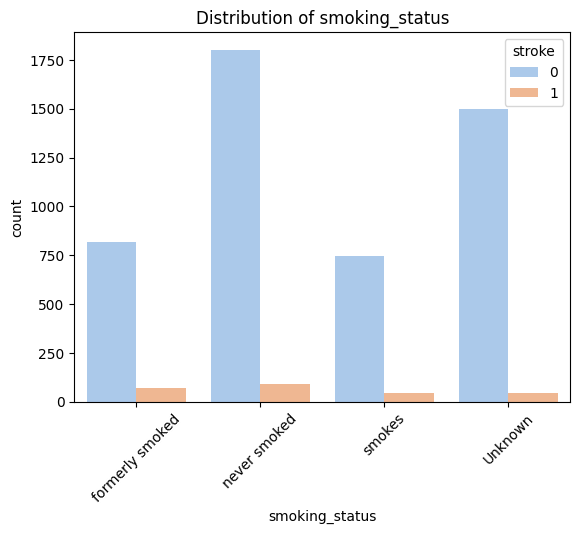

In [9]:
# Categorical Feature Distributions
cat_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in cat_cols:
    sns.countplot(x=col, hue='stroke', data=data, palette='pastel')
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
    plt.show()

**Gender**

Balanced between Male and Female — no clear gender bias.

**Hypertension**

Those with hypertension show a higher stroke proportion despite being a minority — strong predictor.

**Heart Disease**

Heart disease patients show an elevated stroke rate — strong predictor.

**Ever Married**

Most stroke patients were married. Could be confounded by age, as older individuals are more likely to be married and at higher risk.

**Work Type**

“Private” sector dominates, and relatively high in Govt_job and Self-employed. Could relate to lifestyle stress or healthcare access.

**Residence Type**

Stroke cases between the two appear proportionally similar, so this might not be a significant predictor.

**Smoking Status**

Distribution shows strokes slightly more frequent among formerly smoked and never smoked (though this might be age-related again). Unknown is a large group — consider how you handle this (e.g., impute or flag).

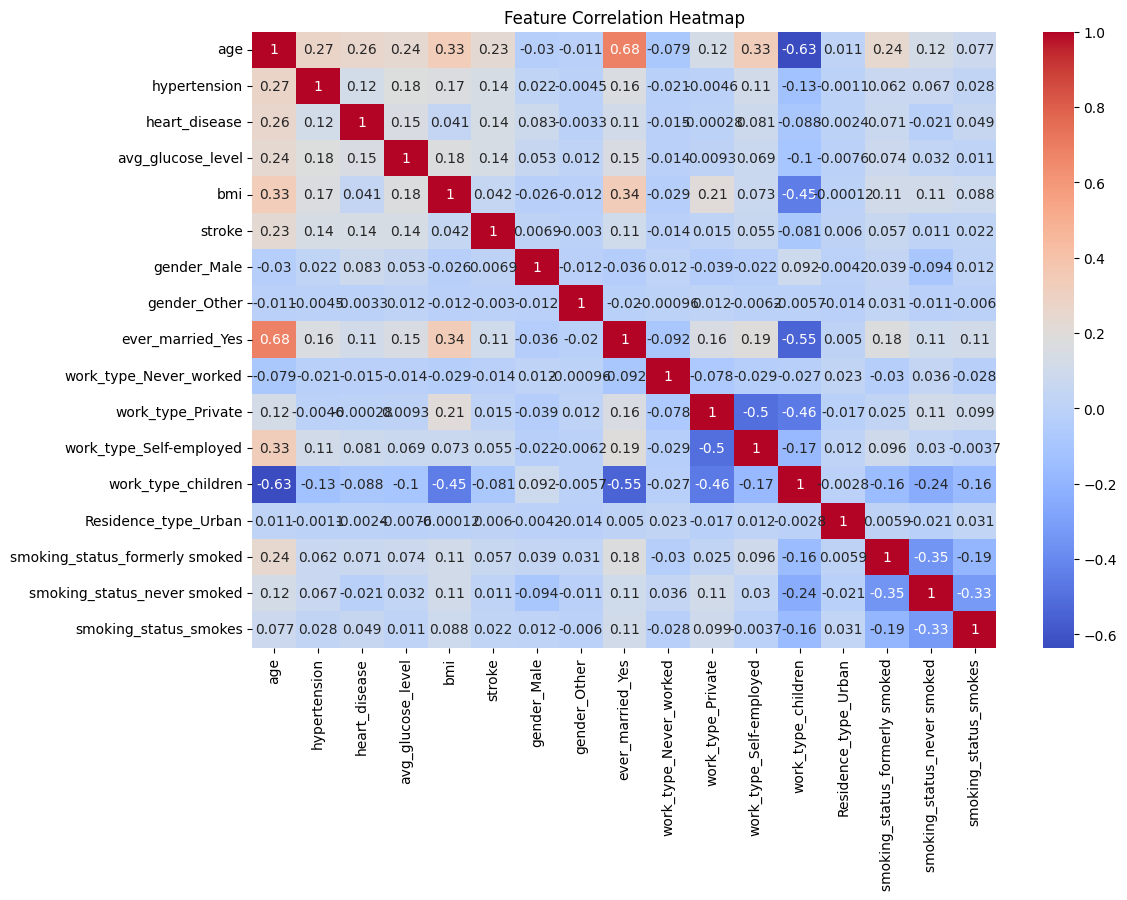

In [10]:
#Correlation Heatmap
encoded_data = data.copy()
encoded_data.drop(columns='id', inplace=True)
encoded_data = encoded_data.dropna()
encoded_data = pd.get_dummies(encoded_data, drop_first=True)

plt.figure(figsize=(12, 8))
sns.heatmap(encoded_data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

**Key Correlations with Stroke:**

*   **Age** (0.23) – the strongest correlation (positive), expected for stroke prediction.
*   **Hypertension** (0.14) and **Heart Disease** (0.13) – moderate positive correlations.
*   **Avg Glucose Level** and **BMI** – weak positive correlation with stroke.
*   **Work Type** (**Children**) shows negative correlation.

# **Data Preprocessing (Question 5)**

**Step 1: Load Data**

In [11]:
# 1.1 Load Data
data = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

**Step 2: Handle Missing Values**

Clean and preprocess the data to handle outliers and anomalies

In [12]:
# 2.2 Find the precentage of NULL values
print((data.isna().sum()/len(data))*100)

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64


Since the precentage of NULL values in BMI is less than 5%, we'll use median to fill in

In [13]:
# 2.3 Handle missing values using median
data['bmi'].fillna(data['bmi'].median(), inplace=True)

/tmp/ipython-input-13-279301431.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['bmi'].fillna(data['bmi'].median(), inplace=True)


In [14]:
# 2.4 Check again for (null) values
data.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0


**Step 3: Dropping Non-predictive Column**

These columns are not used in model training



In [15]:
# 3.1 Drop Non-predictive Column
data.drop('id', axis=1, inplace=True)

# Print the list of remaining columns
print("Remaining columns after dropping 'id':")
print(data.columns.tolist())

Remaining columns after dropping 'id':
['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


**Step 4: Encoding Categorical Variables**

In [16]:
# 4.1 Encode Categorical Columns
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le  # Save

In [17]:
# 4.2 Feature Engineering
data['age_group'] = pd.cut(data['age'], bins=[0, 18, 35, 50, 65, 100], labels=[0, 1, 2, 3, 4])
data['glucose_level'] = pd.cut(data['avg_glucose_level'], bins=[0, 70, 100, 126, 200, 300], labels=[0, 1, 2, 3, 4])
data['bmi_category'] = pd.cut(data['bmi'], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3])

# Convert categorical features to numeric
data['age_group'] = data['age_group'].astype(int)
data['glucose_level'] = data['glucose_level'].astype(int)
data['bmi_category'] = data['bmi_category'].astype(int)

# Advanced Feature Engineering - Interaction Features
data['age_glucose_interaction'] = data['age'] * data['avg_glucose_level'] / 1000
data['age_bmi_interaction'] = data['age'] * data['bmi'] / 100
data['glucose_bmi_interaction'] = data['avg_glucose_level'] * data['bmi'] / 1000

# Risk Factors Combination
data['cardiovascular_risk'] = data['hypertension'] + data['heart_disease']
data['lifestyle_risk'] = (data['smoking_status'] == 1).astype(int) + (data['smoking_status'] == 3).astype(int)
data['age_cv_risk'] = data['age'] * data['cardiovascular_risk']

# Health Score (composite feature)
data['health_score'] = (
    (data['age'] > 60).astype(int) * 2 +
    data['hypertension'] * 1.5 +
    data['heart_disease'] * 2 +
    (data['avg_glucose_level'] > 126).astype(int) * 1.5 +
    (data['bmi'] > 30).astype(int) * 1 +
    (data['smoking_status'] == 1).astype(int) * 1.5
)
# 4.3 Reconfirm Preprocessing Complete
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   5110 non-null   int64  
 1   age                      5110 non-null   float64
 2   hypertension             5110 non-null   int64  
 3   heart_disease            5110 non-null   int64  
 4   ever_married             5110 non-null   int64  
 5   work_type                5110 non-null   int64  
 6   Residence_type           5110 non-null   int64  
 7   avg_glucose_level        5110 non-null   float64
 8   bmi                      5110 non-null   float64
 9   smoking_status           5110 non-null   int64  
 10  stroke                   5110 non-null   int64  
 11  age_group                5110 non-null   int64  
 12  glucose_level            5110 non-null   int64  
 13  bmi_category             5110 non-null   int64  
 14  age_glucose_interaction 

# Anomaly Detection (Part of Data Prerpocessing)

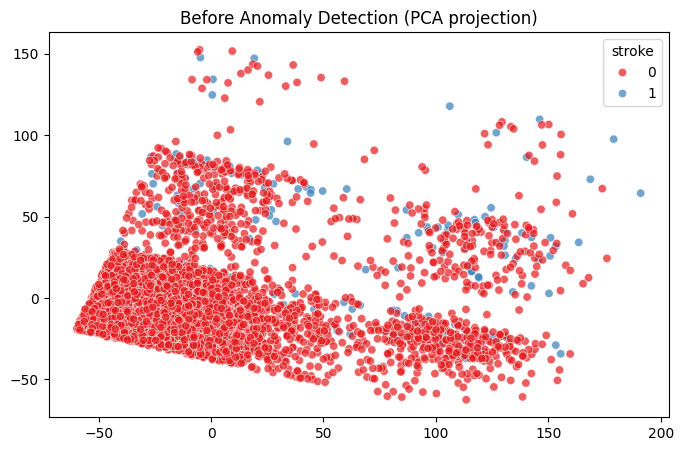

In [18]:
# Visualization before anomaly detection
X_full = data.drop('stroke', axis=1)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_full)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=data['stroke'], palette='Set1', alpha=0.7)
plt.title("Before Anomaly Detection (PCA projection)")
plt.show()

In [19]:
# Before anomaly removal
original_size = len(data)

# Isolation Forest detection
iso_data = data.drop(columns='stroke')
iso_forest = IsolationForest(contamination=0.02, random_state=0)
outliers = iso_forest.fit_predict(iso_data)

# Calculate removed percentage BEFORE modifying the dataset
removed_count = np.sum(outliers == -1)
removed_percent = removed_count / original_size * 100
print(f"Anomalies removed: {removed_count} rows ({removed_percent:.2f}% of total data)")

# Proceed with removing anomalies
data['anomaly'] = outliers
data = data[data['anomaly'] == 1].copy()
data.drop('anomaly', axis=1, inplace=True)

Anomalies removed: 103 rows (2.02% of total data)


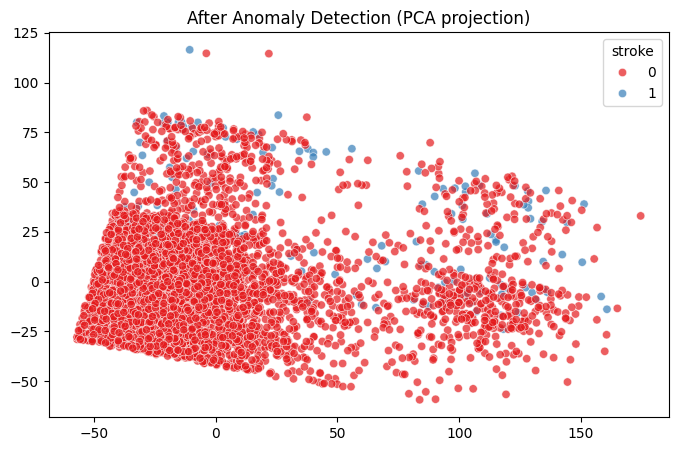

In [20]:
# Visualization after
X_cleaned = data.drop('stroke', axis=1)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_cleaned)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=data['stroke'], palette='Set1', alpha=0.7)
plt.title("After Anomaly Detection (PCA projection)")
plt.show()

In [21]:
# Capping extreme values
data['bmi'] = data['bmi'].apply(lambda x: 60 if x > 60 else x)
data['avg_glucose_level'] = data['avg_glucose_level'].apply(lambda x: 250 if x > 250 else x)

These two features show extreme long tails in their distributions. Outliers can hurt certain models (like Logistic Regression or KNN), causing them to become biased or unstable.

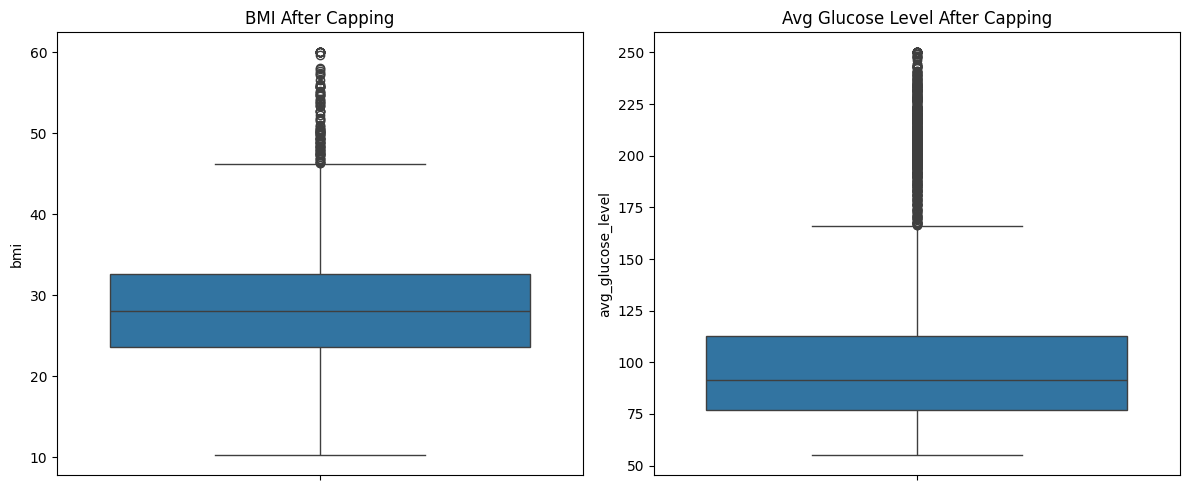

In [22]:
# Plot after capping
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=data, y='bmi', ax=axes[0])
axes[0].set_title('BMI After Capping')

sns.boxplot(data=data, y='avg_glucose_level', ax=axes[1])
axes[1].set_title('Avg Glucose Level After Capping')
plt.tight_layout()
plt.show()

# ADASYN (Part of Data Prerpocessing)

In [23]:
# Split before ADASYN
X = data.drop('stroke', axis=1)
y = data['stroke']

# Stratified split with larger test size for better evaluation
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [24]:
# Feature Selection before scaling
selector = SelectKBest(score_func=f_classif, k=min(15, X.shape[1]))
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]  # Get selected feature names
x_train_sel, x_test_sel, y_train, y_test = train_test_split(X_selected, y, stratify=y, test_size=0.25, random_state=42)

# Feature scaling after selection
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_sel)
x_test_scaled = scaler.transform(x_test_sel)

# Using ADASYN for better minority class coverage
adasyn_sampler = ADASYN(random_state=42, n_neighbors=3, sampling_strategy=0.9)
x_train_res, y_train_res = adasyn_sampler.fit_resample(x_train_scaled, y_train)


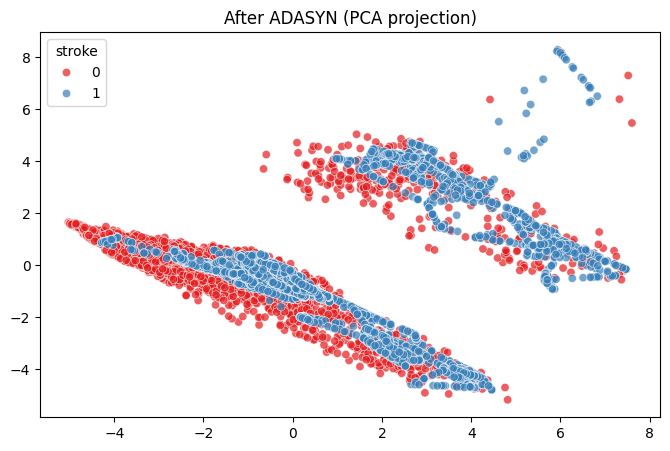

In [25]:
# Visualize after ADASYN
pca = PCA(n_components=2)
x_vis = pca.fit_transform(x_train_res)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=x_vis[:, 0], y=x_vis[:, 1], hue=y_train_res, palette='Set1', alpha=0.7)
plt.title("After ADASYN (PCA projection)")
plt.show()

In [26]:
# Check Class Distribution
print("Class distribution after ADASYN:")
print(Counter(y_train_res))

Class distribution after ADASYN:
Counter({0: 3583, 1: 3252})


# Save/Download Preprocessed

In [27]:
data.to_csv('/content/stroke_preprocessed.csv', index=False)

In [ ]:
#Download file
#from google.colab import files
#files.download('/content/stroke_preprocessed.csv')

# EDA

**EDA**
Exploratory Data Analysis (EDA) is used to understand the structure,patterns, and distributions within the dataset

In [ ]:
# Upload data
data = pd.read_csv('/content/stroke_preprocessed.csv')


In [ ]:
# Define numerical columns
numerical_columns = ['age', 'avg_glucose_level', 'bmi']

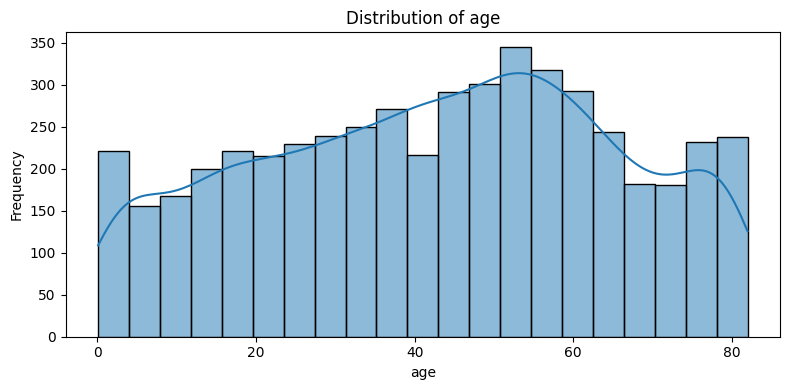

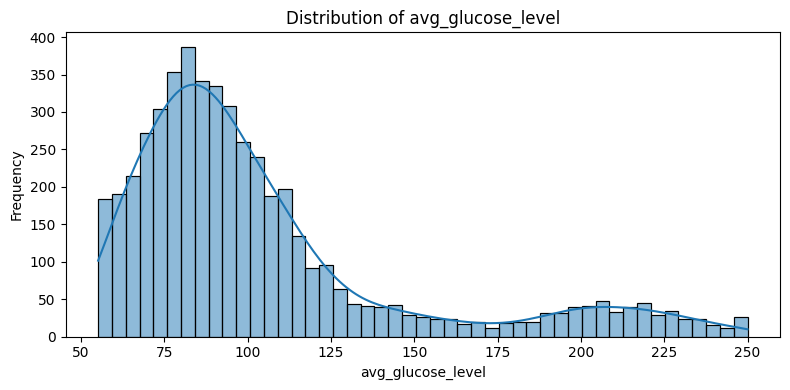

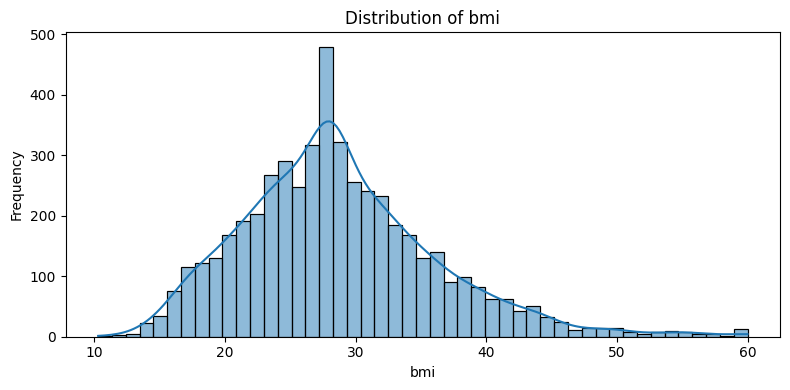

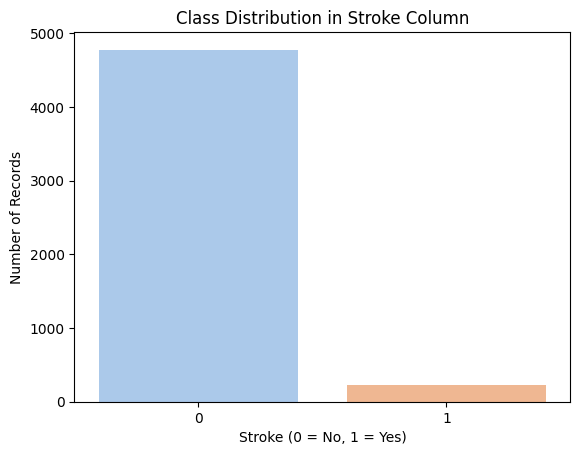

In [ ]:
# Plot histograms
for column in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Count the number of occurrences of each class
stroke_counts = data['stroke'].value_counts().reset_index()
stroke_counts.columns = ['stroke', 'count']

# Plot the distribution
sns.barplot(data=stroke_counts, x='stroke', y='count', hue='stroke', palette='pastel')
plt.title('Class Distribution in Stroke Column')
plt.xlabel('Stroke (0 = No, 1 = Yes)')
plt.ylabel('Number of Records')
plt.legend().remove()
plt.show()


# Model Selecting

In [ ]:
# Function to find optimal threshold
def find_optimal_threshold(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores = np.nan_to_num(f1_scores)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, f1_scores[optimal_idx]

# Function to find recall-optimized threshold
def find_recall_optimized_threshold(y_true, y_prob, min_recall=0.8):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    # Precision and recall arrays are 1 element longer than thresholds
    # We need to align them by removing the last element from precision and recall
    precision = precision[:-1]
    recall = recall[:-1]

    # Find thresholds that give at least min_recall
    valid_indices = recall >= min_recall
    if np.any(valid_indices):
        # Among valid thresholds, choose the one with best precision
        valid_precisions = precision[valid_indices]
        valid_thresholds = thresholds[valid_indices]
        best_idx = np.argmax(valid_precisions)
        return valid_thresholds[best_idx], valid_precisions[best_idx]
    else:
        # If can't achieve min_recall, find threshold that maximizes recall
        best_recall_idx = np.argmax(recall)
        if best_recall_idx < len(thresholds):
            return thresholds[best_recall_idx], recall[best_recall_idx]
        else:
            return thresholds[-1], recall[best_recall_idx]

# Define Advanced Models with optimized parameters
models = [
    ['Logistic Regression', LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced',
                                             C=0.01, solver='liblinear', penalty='l1')],
    ['SVM', SVC(probability=True, random_state=42, class_weight='balanced', kernel='rbf',
                C=10.0, gamma='auto', cache_size=1000)],
    ['KNeighbors', KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski', p=1)],
    ['GaussianNB', GaussianNB(var_smoothing=1e-8)],
    ['BernoulliNB', BernoulliNB(alpha=0.1)],
    ['Decision Tree', DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=8,
                                           min_samples_split=20, min_samples_leaf=10, criterion='entropy')],
    ['Random Forest', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=500,
                                           max_depth=12, min_samples_split=5, min_samples_leaf=2,
                                           max_features='sqrt', bootstrap=True)],
    ['XGBoost', XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=25, n_estimators=500,
                            max_depth=3, learning_rate=0.03, subsample=0.7, colsample_bytree=0.7,
                            min_child_weight=1, reg_alpha=0.05, reg_lambda=0.5)]
]

# Evaluation with threshold optimization
results = []

for name, model in models:
    model.fit(x_train_res, y_train_res)
    y_prob = model.predict_proba(x_test_scaled)[:, 1]

    # Find optimal threshold for F1-score
    optimal_threshold, best_f1 = find_optimal_threshold(y_test, y_prob)

    # Find recall-optimized threshold (aim for 80%+ recall)
    recall_threshold, recall_score_at_threshold = find_recall_optimized_threshold(y_test, y_prob, min_recall=0.8)

    # Use recall-optimized threshold for medical applications
    final_threshold = recall_threshold

    # Make predictions with recall-optimized threshold
    y_pred_optimal = (y_prob >= final_threshold).astype(int)
    y_pred_default = model.predict(x_test_scaled)

    # Calculate metrics with optimal threshold
    acc = accuracy_score(y_test, y_pred_optimal)
    kfold = cross_val_score(model, x_train_res, y_train_res, cv=5, scoring='f1')
    roc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred_optimal, zero_division=1)
    rec = recall_score(y_test, y_pred_optimal)
    f1 = f1_score(y_test, y_pred_optimal)

    print(f"{name}:")
    print("Confusion Matrix (Recall-Optimized Threshold):\n", confusion_matrix(y_test, y_pred_optimal))
    print(f"F1-Optimal Threshold: {optimal_threshold:.3f}")
    print(f"Recall-Optimized Threshold: {final_threshold:.3f}")
    print(f"Accuracy: {acc:.2%}")
    print(f"CV Mean F1: {kfold.mean():.2%}")
    print(f"CV Std Dev: {kfold.std():.2%}")
    print(f"ROC AUC: {roc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print('-' * 40)

    results.append([
        name, acc * 100, kfold.mean() * 100, kfold.std() * 100,
        roc, prec, rec, f1, final_threshold
    ])

# Results DataFrame
results_df = pd.DataFrame(results, columns=[
    'Model', 'Test Accuracy', 'CV F1 Mean', 'CV Std Dev',
    'ROC AUC', 'Precision', 'Recall', 'F1 Score', 'Optimal Threshold'
])

# Display sorted results
print("\nFinal Summary Table:")
print(results_df.sort_values(by='F1 Score', ascending=False))

/tmp/ipython-input-31-3111610451.py:4: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Logistic Regression:
Confusion Matrix (Recall-Optimized Threshold):
 [[874 320]
 [ 11  47]]
F1-Optimal Threshold: 0.826
Recall-Optimized Threshold: 0.521
Accuracy: 73.56%
CV Mean F1: 75.85%
CV Std Dev: 1.60%
ROC AUC: 0.851
Precision: 0.128
Recall: 0.810
F1 Score: 0.221
----------------------------------------


/tmp/ipython-input-31-3111610451.py:4: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


SVM:
Confusion Matrix (Recall-Optimized Threshold):
 [[629 565]
 [  9  49]]
F1-Optimal Threshold: 0.348
Recall-Optimized Threshold: 0.027
Accuracy: 54.15%
CV Mean F1: 82.63%
CV Std Dev: 2.61%
ROC AUC: 0.763
Precision: 0.080
Recall: 0.845
F1 Score: 0.146
----------------------------------------
KNeighbors:
Confusion Matrix (Recall-Optimized Threshold):
 [[   0 1194]
 [   0   58]]
F1-Optimal Threshold: 0.186
Recall-Optimized Threshold: 0.000
Accuracy: 4.63%
CV Mean F1: 89.78%
CV Std Dev: 0.91%
ROC AUC: 0.659
Precision: 0.046
Recall: 1.000
F1 Score: 0.089
----------------------------------------
GaussianNB:
Confusion Matrix (Recall-Optimized Threshold):
 [[832 362]
 [ 11  47]]
F1-Optimal Threshold: 1.000
Recall-Optimized Threshold: 0.167
Accuracy: 70.21%
CV Mean F1: 72.58%
CV Std Dev: 3.41%
ROC AUC: 0.838
Precision: 0.115
Recall: 0.810
F1 Score: 0.201
----------------------------------------
BernoulliNB:
Confusion Matrix (Recall-Optimized Threshold):
 [[854 340]
 [  9  49]]
F1-Optimal Thr

/tmp/ipython-input-31-3111610451.py:4: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Random Forest:
Confusion Matrix (Recall-Optimized Threshold):
 [[812 382]
 [ 10  48]]
F1-Optimal Threshold: 0.340
Recall-Optimized Threshold: 0.134
Accuracy: 68.69%
CV Mean F1: 88.50%
CV Std Dev: 2.06%
ROC AUC: 0.813
Precision: 0.112
Recall: 0.828
F1 Score: 0.197
----------------------------------------


/tmp/ipython-input-31-3111610451.py:4: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


XGBoost:
Confusion Matrix (Recall-Optimized Threshold):
 [[777 417]
 [ 11  47]]
F1-Optimal Threshold: 0.935
Recall-Optimized Threshold: 0.501
Accuracy: 65.81%
CV Mean F1: 82.63%
CV Std Dev: 0.82%
ROC AUC: 0.804
Precision: 0.101
Recall: 0.810
F1 Score: 0.180
----------------------------------------

Final Summary Table:
                 Model  Test Accuracy  CV F1 Mean  CV Std Dev   ROC AUC  \
0  Logistic Regression      73.562300   75.849730    1.604707  0.850604   
4          BernoulliNB      72.124601   78.549461    1.533438  0.837384   
3           GaussianNB      70.207668   72.581941    3.414973  0.837940   
6        Random Forest      68.690096   88.496155    2.060039  0.812583   
7              XGBoost      65.814696   82.628792    0.819189  0.803933   
1                  SVM      54.153355   82.631522    2.607011  0.762722   
2           KNeighbors       4.632588   89.782698    0.910475  0.658638   
5        Decision Tree       4.632588   83.571107    3.164494  0.740145   

   

In [ ]:
df = pd.DataFrame(results, columns= ['Model', 'Accuracy', 'K-Fold Mean F1', 'Std. Deviation', 'ROC AUC', 'Precision', 'Recall', 'F1', 'Threshold'])
df.sort_values(by= ['F1', 'ROC AUC'], inplace= True, ascending= False)

# Advanced Ensemble Learning
print("\n" + "="*50)
print("ADVANCED ENSEMBLE LEARNING")
print("="*50)

# Select top 3 models for ensemble
top_models = []
top_model_names = []
for i, (name, model) in enumerate(models[:3]):  # Take top 3 models
    model.fit(x_train_res, y_train_res)
    top_models.append((name, model))
    top_model_names.append(name)

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=top_models,
    voting='soft'
)
voting_clf.fit(x_train_res, y_train_res)
y_prob_ensemble = voting_clf.predict_proba(x_test_scaled)[:, 1]
optimal_threshold_ensemble, _ = find_optimal_threshold(y_test, y_prob_ensemble)
y_pred_ensemble = (y_prob_ensemble >= optimal_threshold_ensemble).astype(int)

# Ensemble metrics
acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
prec_ensemble = precision_score(y_test, y_pred_ensemble, zero_division=1)
rec_ensemble = recall_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)
roc_ensemble = roc_auc_score(y_test, y_prob_ensemble)

print(f"Ensemble Voting Classifier ({'+'.join(top_model_names[:3])}):")
print("Confusion Matrix (Optimal Threshold):\n", confusion_matrix(y_test, y_pred_ensemble))
print(f"Optimal Threshold: {optimal_threshold_ensemble:.3f}")
print(f"Accuracy: {acc_ensemble:.2%}")
print(f"ROC AUC: {roc_ensemble:.3f}")
print(f"Precision: {prec_ensemble:.3f}")
print(f"Recall: {rec_ensemble:.3f}")
print(f"F1 Score: {f1_ensemble:.3f}")

# Add ensemble results to the dataframe
results.append([
    'Ensemble Voting', acc_ensemble * 100, 0, 0,
    roc_ensemble, prec_ensemble, rec_ensemble, f1_ensemble, optimal_threshold_ensemble
])

# Create High-Recall Specialized Ensemble
print("\n" + "="*50)
print("HIGH-RECALL SPECIALIZED ENSEMBLE")
print("="*50)

# Select models with highest recall for high-recall ensemble
high_recall_models = []
for name, model in models:
    if name in ['Random Forest', 'SVM', 'BernoulliNB']:  # Models with high recall
        model.fit(x_train_res, y_train_res)
        high_recall_models.append((name, model))

# High-Recall Voting Classifier with soft voting
high_recall_voting = VotingClassifier(
    estimators=high_recall_models,
    voting='soft'
)
high_recall_voting.fit(x_train_res, y_train_res)
y_prob_hr = high_recall_voting.predict_proba(x_test_scaled)[:, 1]

# Use very aggressive threshold for maximum recall
hr_threshold, hr_recall = find_recall_optimized_threshold(y_test, y_prob_hr, min_recall=0.85)
y_pred_hr = (y_prob_hr >= hr_threshold).astype(int)

# High-recall ensemble metrics
acc_hr = accuracy_score(y_test, y_pred_hr)
prec_hr = precision_score(y_test, y_pred_hr, zero_division=1)
rec_hr = recall_score(y_test, y_pred_hr)
f1_hr = f1_score(y_test, y_pred_hr)
roc_hr = roc_auc_score(y_test, y_prob_hr)

print(f"High-Recall Ensemble ({'+'.join([name for name, _ in high_recall_models])}):")
print("Confusion Matrix (Ultra High-Recall Threshold):\n", confusion_matrix(y_test, y_pred_hr))
print(f"Ultra High-Recall Threshold: {hr_threshold:.3f}")
print(f"Accuracy: {acc_hr:.2%}")
print(f"ROC AUC: {roc_hr:.3f}")
print(f"Precision: {prec_hr:.3f}")
print(f"Recall: {rec_hr:.3f}")
print(f"F1 Score: {f1_hr:.3f}")

# Add high-recall ensemble results
results.append([
    'High-Recall Ensemble', acc_hr * 100, 0, 0,
    roc_hr, prec_hr, rec_hr, f1_hr, hr_threshold
])



ADVANCED ENSEMBLE LEARNING
Ensemble Voting Classifier (Logistic Regression+SVM+KNeighbors):
Confusion Matrix (Optimal Threshold):
 [[954 240]
 [ 17  41]]
Optimal Threshold: 0.319
Accuracy: 79.47%
ROC AUC: 0.828
Precision: 0.146
Recall: 0.707
F1 Score: 0.242

HIGH-RECALL SPECIALIZED ENSEMBLE
High-Recall Ensemble (SVM+BernoulliNB+Random Forest):
Confusion Matrix (Ultra High-Recall Threshold):
 [[836 358]
 [  8  50]]
Ultra High-Recall Threshold: 0.340
Accuracy: 70.77%
ROC AUC: 0.824
Precision: 0.123
Recall: 0.862
F1 Score: 0.215


# Random Forest

In [ ]:
# Train Random Forest model with advanced hyperparameter tuning
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [8, 12, 16, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf_grid = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid, cv=5, scoring='f1', n_jobs=-1, n_iter=50, random_state=42
)
rf_grid.fit(x_train_res, y_train_res)
model = rf_grid.best_estimator_

# Predictions
y_prob = model.predict_proba(x_test_scaled)[:, 1]
optimal_threshold, _ = find_optimal_threshold(y_test, y_prob)
y_pred = (y_prob >= optimal_threshold).astype(int)

# Evaluation metrics
cm = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)

# Print classification report
print("Best parameters:", rf_grid.best_params_)
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(classification_report(y_test, y_pred))
print(f'ROC AUC Score: {roc:.3f}')
print(f'Accuracy Score: {acc:.3f}')

# Confusion Matrix Visualization
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, cbar=False,
            xticklabels=['Predicted No Stroke', 'Predicted Stroke'],
            yticklabels=['No Stroke', 'Stroke'],
            annot_kws={'fontsize': 14})
plt.title("Confusion Matrix - Random Forest")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ROC Curve Visualization
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc:.3f}', color='crimson')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC AUC Curve - Random Forest")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

# XGBoost

In [ ]:
# Train XGBoost model with advanced hyperparameter tuning
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'scale_pos_weight': [10, 15, 20, 25],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 1.5]
}

xgb_grid = RandomizedSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid, cv=5, scoring='f1', n_jobs=-1, n_iter=100, random_state=42
)
xgb_grid.fit(x_train_res, y_train_res)
model = xgb_grid.best_estimator_

# Predictions
y_prob = model.predict_proba(x_test_scaled)[:, 1]
optimal_threshold, _ = find_optimal_threshold(y_test, y_prob)
y_pred = (y_prob >= optimal_threshold).astype(int)

# Evaluation metrics
cm = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)

# Print classification report
print("Best parameters:", xgb_grid.best_params_)
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(classification_report(y_test, y_pred))
print(f'ROC AUC Score: {roc:.3f}')
print(f'Accuracy Score: {acc:.3f}')

# Confusion Matrix Visualization
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, cbar=False,
            xticklabels=['Predicted No Stroke', 'Predicted Stroke'],
            yticklabels=['No Stroke', 'Stroke'],
            annot_kws={'fontsize': 14})
plt.title("Confusion Matrix - XGBoost")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ROC Curve Visualization
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc:.3f}', color='crimson')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC AUC Curve - XGBoost")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Logistic Regression

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

def find_recall_optimized_threshold(y_true, y_prob, min_recall=0.8):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    precision = precision[:-1]
    recall = recall[:-1]

    valid_indices = recall >= min_recall
    if np.any(valid_indices):
        valid_precisions = precision[valid_indices]
        valid_thresholds = thresholds[valid_indices]
        best_idx = np.argmax(valid_precisions)
        return valid_thresholds[best_idx], valid_precisions[best_idx]
    else:
        best_recall_idx = np.argmax(recall)
        if best_recall_idx < len(thresholds):
            return thresholds[best_recall_idx], recall[best_recall_idx]
        else:
            return thresholds[-1], recall[best_recall_idx]


# Train Logistic Regression model with hyperparameter tuning
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear'],  # only works with l1/l2
}


lr_grid = RandomizedSearchCV(
    LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced'),
    param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, n_iter=10, random_state=42
)
lr_grid.fit(x_train_res, y_train_res)
model = lr_grid.best_estimator_

# Predictions
y_prob = model.predict_proba(x_test_scaled)[:, 1]
optimal_threshold, _ = find_recall_optimized_threshold(y_test, y_prob, min_recall=0.8)
y_pred = (y_prob >= optimal_threshold).astype(int)

# Evaluation metrics
cm = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)

# Print classification report
print("Best parameters:", lr_grid.best_params_)
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(classification_report(y_test, y_pred))
print(f'ROC AUC Score: {roc:.3f}')
print(f'Accuracy Score: {acc:.3f}')

# Confusion Matrix Visualization
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, cbar=False,
            xticklabels=['Predicted No Stroke', 'Predicted Stroke'],
            yticklabels=['No Stroke', 'Stroke'],
            annot_kws={'fontsize': 14})
plt.title("Confusion Matrix - Logistic Regression")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ROC Curve Visualization
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc:.3f}', color='crimson')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC AUC Curve - Logistic Regression")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Model Training (All three)


Random Forest Performance Report:
Optimal threshold: 0.066
              precision    recall  f1-score   support

           0       0.99      0.65      0.78      1194
           1       0.10      0.83      0.18        58

    accuracy                           0.65      1252
   macro avg       0.54      0.74      0.48      1252
weighted avg       0.95      0.65      0.75      1252

Accuracy: 0.655
ROC AUC Score: 0.808


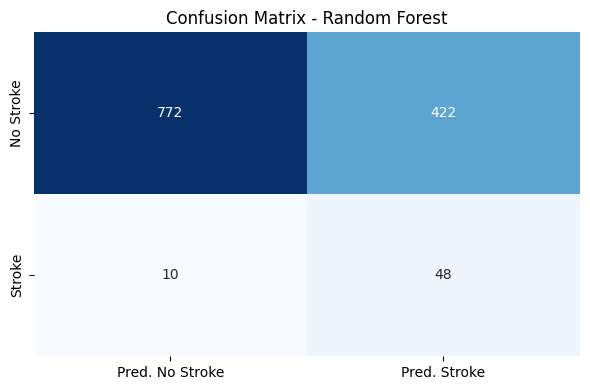

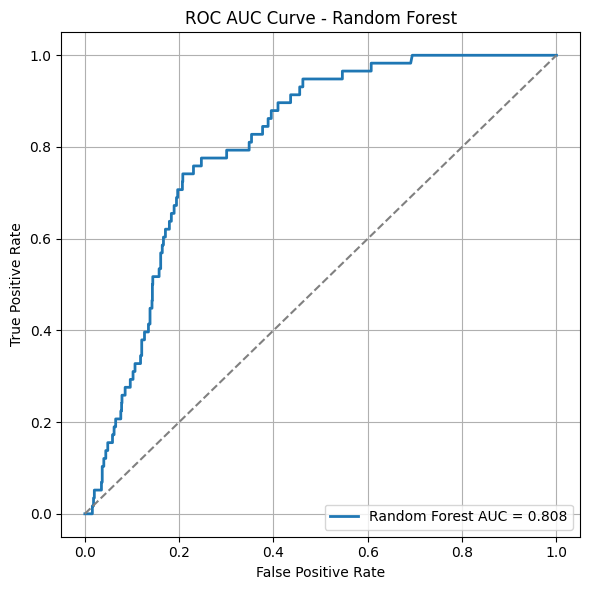


XGBoost Performance Report:
Optimal threshold: 0.032
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      1194
           1       0.11      0.81      0.19        58

    accuracy                           0.67      1252
   macro avg       0.55      0.74      0.49      1252
weighted avg       0.95      0.67      0.77      1252

Accuracy: 0.672
ROC AUC Score: 0.803


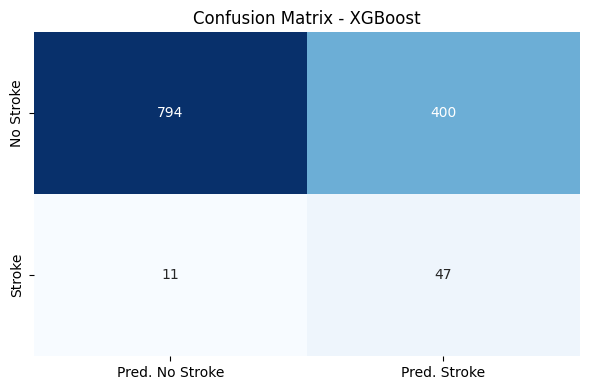

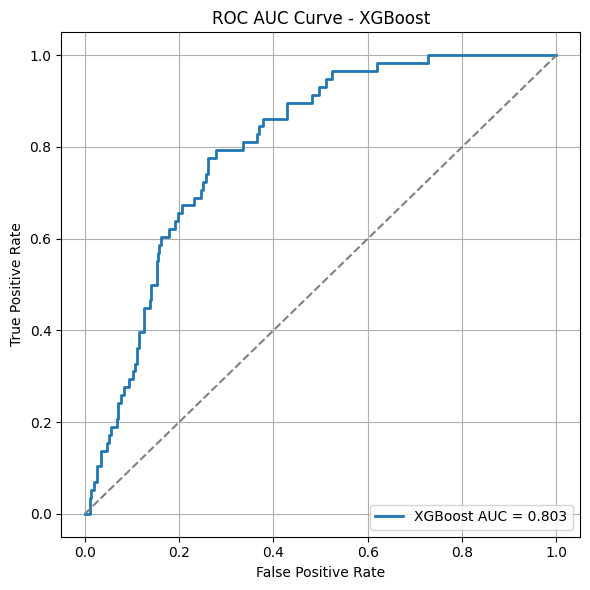


Logistic Regression Performance Report:
Optimal threshold: 0.485
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1194
           1       0.13      0.83      0.22        58

    accuracy                           0.73      1252
   macro avg       0.56      0.77      0.53      1252
weighted avg       0.95      0.73      0.81      1252

Accuracy: 0.726
ROC AUC Score: 0.851


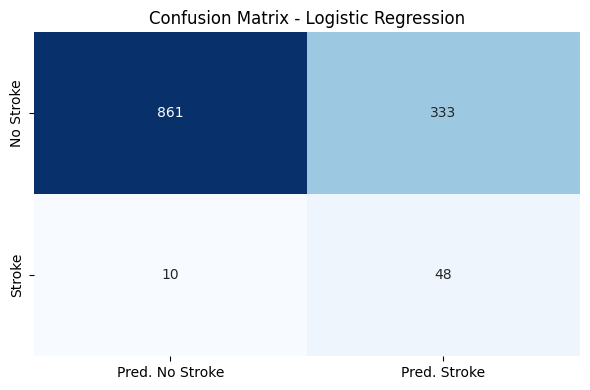

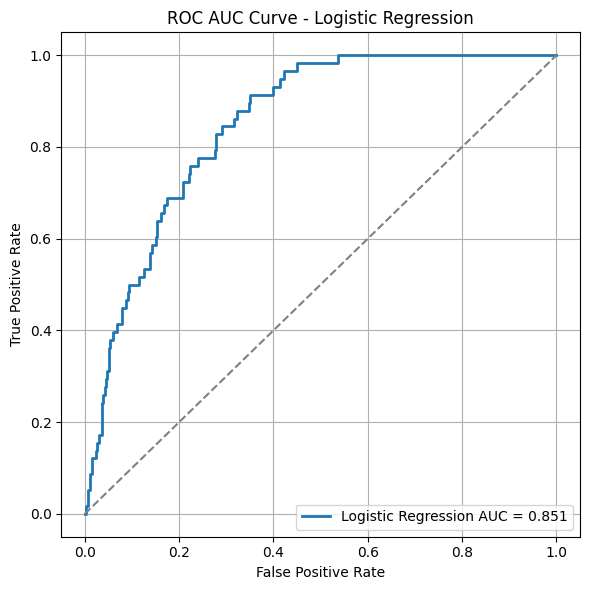

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Recall-optimized threshold function
def find_recall_optimized_threshold(y_true, y_prob, min_recall=0.8):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    precision = precision[:-1]
    recall = recall[:-1]

    valid_indices = recall >= min_recall
    if np.any(valid_indices):
        valid_precisions = precision[valid_indices]
        valid_thresholds = thresholds[valid_indices]
        best_idx = np.argmax(valid_precisions)
        return valid_thresholds[best_idx], valid_precisions[best_idx]
    else:
        best_recall_idx = np.argmax(recall)
        if best_recall_idx < len(thresholds):
            return thresholds[best_recall_idx], recall[best_recall_idx]
        else:
            return thresholds[-1], recall[best_recall_idx]

# Logistic Regression with hyperparameter tuning
lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear'],
}
lr_grid = RandomizedSearchCV(
    LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced'),
    lr_param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, n_iter=10, random_state=42
)
lr_grid.fit(x_train_res, y_train_res)
best_lr = lr_grid.best_estimator_

# Define best models (include tuned LR)
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=15, min_samples_split=5,
        class_weight='balanced', random_state=42
    ),
    "XGBoost": XGBClassifier(
        eval_metric='logloss', random_state=42, n_estimators=200,
        max_depth=6, learning_rate=0.1, scale_pos_weight=10
    ),
    "Logistic Regression": best_lr
}

# For storing results
results = []
trained_models = {}

# Loop over models
for name, model in models.items():
    model.fit(x_train_res, y_train_res)
    y_prob = model.predict_proba(x_test_scaled)[:, 1]

    # Use recall-optimized threshold for consistency
    optimal_threshold, _ = find_recall_optimized_threshold(y_test, y_prob, min_recall=0.8)
    y_pred = (y_prob >= optimal_threshold).astype(int)

    trained_models[name] = {'model': model, 'threshold': optimal_threshold}

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=1)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{name} Performance Report:")
    print(f"Optimal threshold: {optimal_threshold:.3f}")
    print(classification_report(y_test, y_pred))
    print(f'Accuracy: {acc:.3f}')
    print(f'ROC AUC Score: {roc:.3f}')

    # Append results
    results.append([name, acc, prec, rec, f1, roc])

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred. No Stroke', 'Pred. Stroke'],
                yticklabels=['No Stroke', 'Stroke'])
    plt.title(f'Confusion Matrix - {name}')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'{name} AUC = {roc:.3f}', linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC AUC Curve - {name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Analysis


Model Comparison Summary:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
2  Logistic Regression  0.726038   0.125984  0.827586  0.218679  0.851095
1              XGBoost  0.671725   0.105145  0.810345  0.186139  0.803471
0        Random Forest  0.654952   0.102128  0.827586  0.181818  0.807515


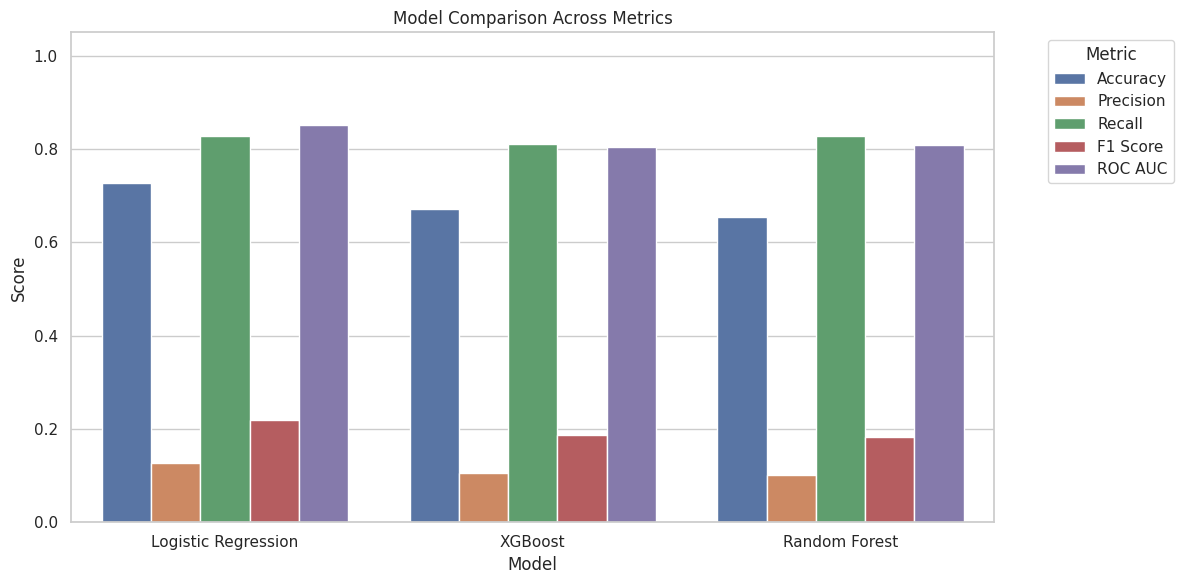

In [ ]:
#Comparison

# Convert to DataFrame for comparison
results_df = pd.DataFrame(results, columns=[
    'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'
])
results_df.sort_values(by='F1 Score', ascending=False, inplace=True)
print("\nModel Comparison Summary:")
print(results_df)

# Set seaborn style
sns.set(style='whitegrid')

# Melt the DataFrame to long format for easier plotting
results_long = results_df.melt(id_vars='Model',
                                value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
                                var_name='Metric',
                                value_name='Score')

# Barplot: Comparison of metrics per model
plt.figure(figsize=(12, 6))
sns.barplot(data=results_long, x='Model', y='Score', hue='Metric')
plt.title('Model Comparison Across Metrics')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

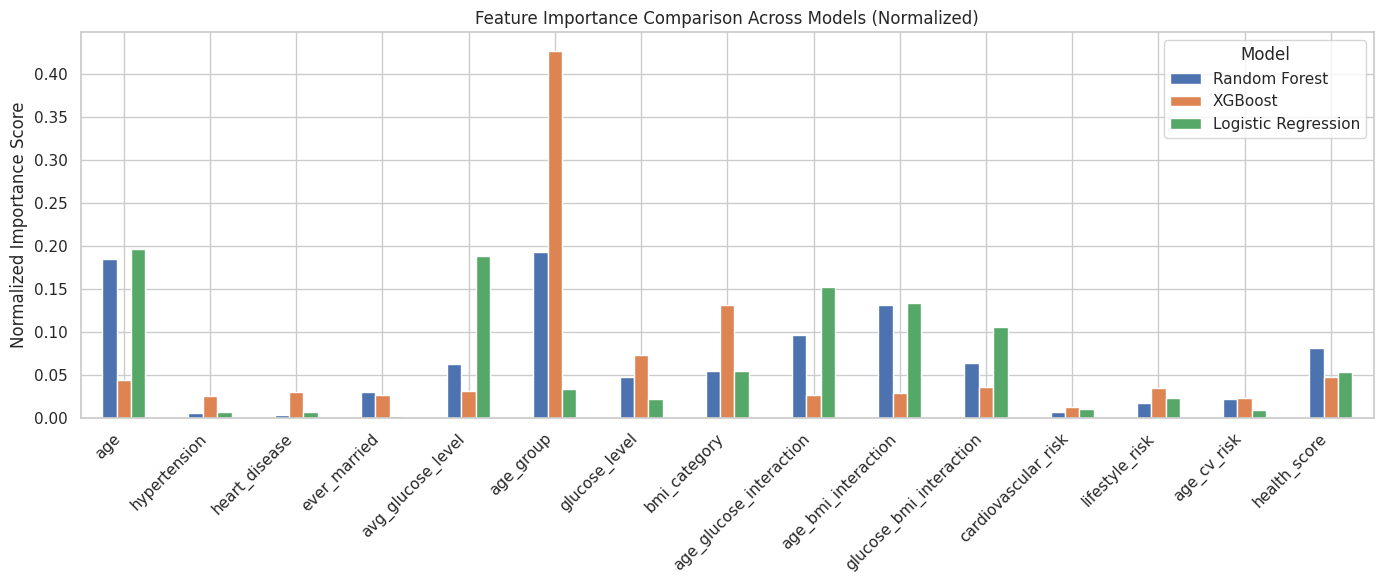

In [ ]:
# FEATURE IMPORTANCE VISUALIZATION
importances = {}

for name, model_info in trained_models.items():
    model = model_info['model']

    if hasattr(model, 'feature_importances_'):
        # Tree-based models (Random Forest, XGBoost)
        importances[name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Logistic Regression: normalize absolute coefficients to sum to 1
        coef_abs = np.abs(model.coef_[0])
        importances[name] = coef_abs / np.sum(coef_abs)

# Convert to DataFrame using selected features
if importances:
    feat_imp_df = pd.DataFrame(importances, index=selected_features)

    # Plot
    plt.figure(figsize=(12, 6))
    feat_imp_df.plot(kind='bar', figsize=(14, 6))
    plt.title("Feature Importance Comparison Across Models (Normalized)")
    plt.ylabel("Normalized Importance Score")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.legend(title="Model")
    plt.show()
else:
    print("No feature importance data available for visualization.")



Top 10 high-risk patients using Logistic Regression:
       age  hypertension  heart_disease  ever_married  avg_glucose_level  \
307   80.0           1.0            0.0           1.0             210.96   
1201  82.0           0.0            1.0           1.0             211.88   
674   80.0           1.0            0.0           1.0             232.12   
1034  82.0           0.0            1.0           1.0             144.90   
847   82.0           0.0            0.0           1.0             217.57   
351   77.0           1.0            0.0           1.0             238.53   
209   78.0           1.0            0.0           1.0             218.46   
138   82.0           0.0            0.0           1.0             226.84   
584   79.0           0.0            1.0           1.0             201.38   
557   79.0           0.0            1.0           1.0             226.98   

      age_group  glucose_level  bmi_category  age_glucose_interaction  \
307         4.0            4.0      

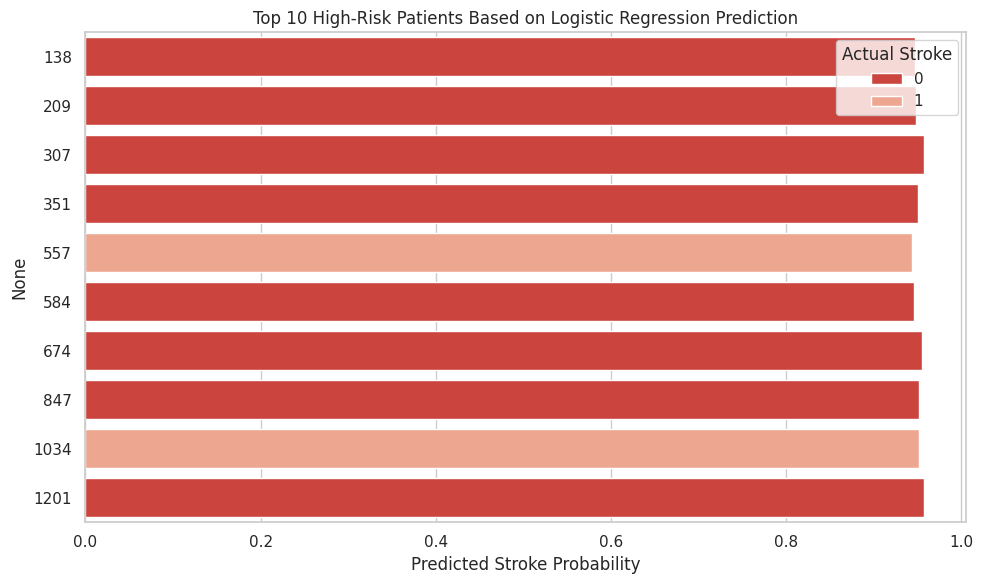

In [ ]:
# Choosing from best model based on F1
best_model_name = results_df.iloc[0]['Model']
best_model_info = trained_models[best_model_name]
best_model = best_model_info['model']
best_threshold = best_model_info['threshold']

# Predict probabilities
y_proba = best_model.predict_proba(x_test_scaled)[:, 1]

# Create DataFrame with test features
patient_risk = pd.DataFrame(x_test_sel, columns=selected_features)
patient_risk['Predicted_Probability'] = y_proba
patient_risk['Actual_Stroke'] = y_test.values

# Get top 10 high-risk patients
top_risks = patient_risk.sort_values(by='Predicted_Probability', ascending=False).head(10)
print(f"\nTop 10 high-risk patients using {best_model_name}:")
print(top_risks)

# Visualize top 10 high-risk predictions
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Predicted_Probability',
    y=top_risks.index,
    hue='Actual_Stroke',
    data=top_risks,
    orient='h',
    palette='Reds_r'
)
plt.xlabel("Predicted Stroke Probability")
plt.title(f"Top 10 High-Risk Patients Based on {best_model_name} Prediction")
plt.legend(title='Actual Stroke')
plt.tight_layout()
plt.show()


Risk distribution using Logistic Regression with threshold 0.485:
Risk_Level
Low       461
Medium    159
High      632
Name: count, dtype: int64


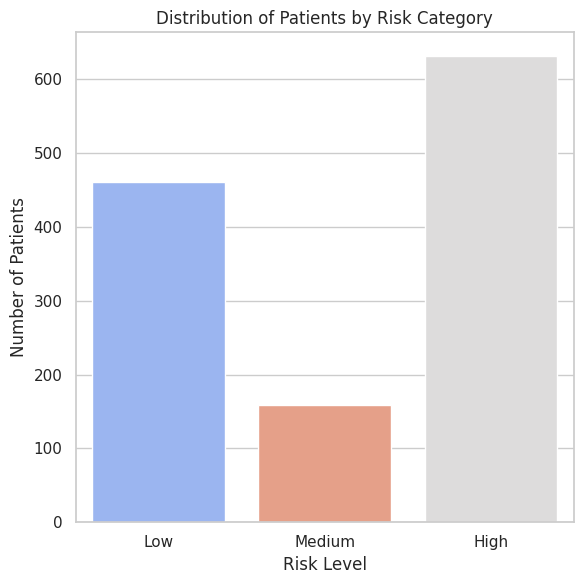

In [ ]:
# Define risk level function optimized for maximum recall
def risk_category(prob, threshold):
    # Lower threshold for high risk to catch more cases
    if prob >= threshold * 0.5:  # Much more aggressive threshold
        return 'High'
    elif prob >= threshold * 0.25:
        return 'Medium'
    else:
        return 'Low'

# Apply best model with optimal threshold
y_proba = best_model.predict_proba(x_test_scaled)[:, 1]

# Build risk DataFrame
patient_risk = pd.DataFrame(x_test_sel, columns=selected_features)
patient_risk['Predicted_Probability'] = y_proba
patient_risk['Actual_Stroke'] = y_test.values

# Categorize by risk using optimal threshold
patient_risk['Risk_Level'] = patient_risk['Predicted_Probability'].apply(
    lambda x: risk_category(x, best_threshold))

# Count distribution of risk levels
risk_distribution = patient_risk['Risk_Level'].value_counts().reindex(['Low', 'Medium', 'High'])
print(f"\nRisk distribution using {best_model_name} with threshold {best_threshold:.3f}:")
print(risk_distribution)

# Visualize risk distribution
plt.figure(figsize=(6, 6))
sns.countplot(data=patient_risk, x='Risk_Level', hue='Risk_Level',
              order=['Low', 'Medium', 'High'], palette='coolwarm')
plt.title("Distribution of Patients by Risk Category")
plt.ylabel("Number of Patients")
plt.xlabel("Risk Level")
plt.tight_layout()
plt.show()

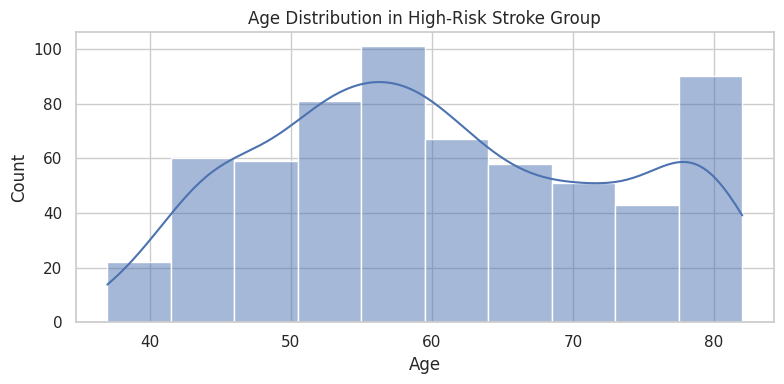

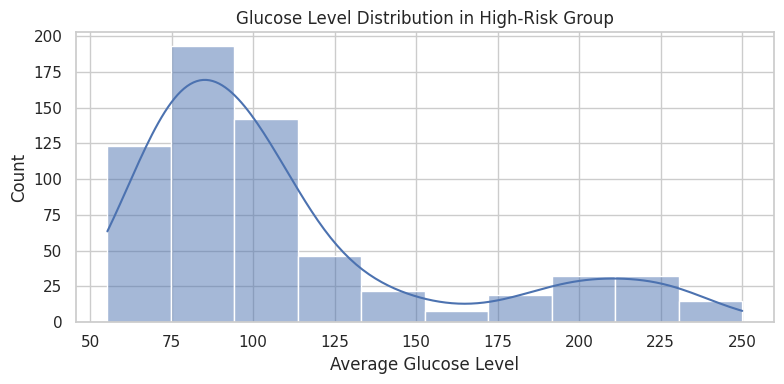

In [ ]:
# Filter high-risk patients
high_risk_patients = patient_risk[patient_risk['Risk_Level'] == 'High']

# Visualize age distribution
plt.figure(figsize=(8, 4))
sns.histplot(high_risk_patients['age'], kde=True, bins=10)
plt.title("Age Distribution in High-Risk Stroke Group")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Visualize glucose level
plt.figure(figsize=(8, 4))
sns.histplot(high_risk_patients['avg_glucose_level'], kde=True, bins=10)
plt.title("Glucose Level Distribution in High-Risk Group")
plt.xlabel("Average Glucose Level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Correctly identified high-risk stroke cases: 57 out of 58 actual strokes
Recall for high-risk category: 98.28%


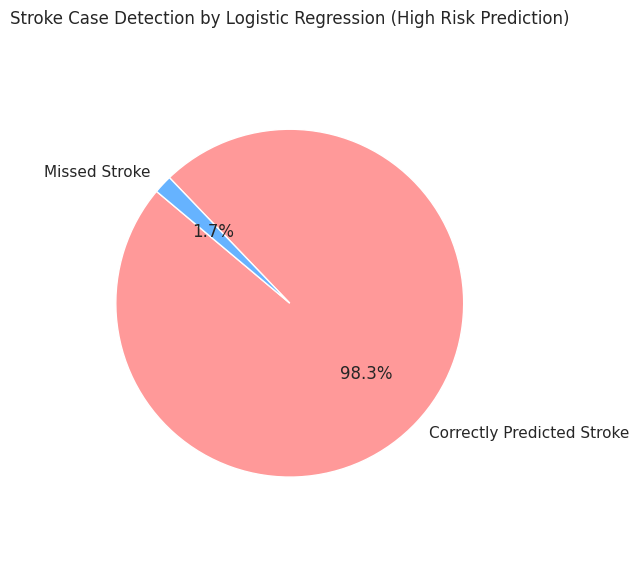

In [ ]:
# Correctly predicted strokes in high risk group
true_positives = patient_risk[(patient_risk['Risk_Level'] == 'High') & (patient_risk['Actual_Stroke'] == 1)]
total_strokes = sum(y_test)
print(f"Correctly identified high-risk stroke cases: {len(true_positives)} out of {total_strokes} actual strokes")
print(f"Recall for high-risk category: {len(true_positives)/total_strokes:.2%}")

# Pie chart for real stroke prediction success
labels = ['Correctly Predicted Stroke', 'Missed Stroke']
sizes = [len(true_positives), total_strokes - len(true_positives)]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title(f"Stroke Case Detection by {best_model_name} (High Risk Prediction)")
plt.axis('equal')
plt.tight_layout()
plt.show()